In [1]:
# -*- coding: utf-8 -*-
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import os, cv2
from osgeo import gdal, osr, ogr
from tqdm import tqdm_notebook
from glob import glob
from scipy import ndimage

# 裁剪图片

In [2]:
data_dir = "/Users/mac/Desktop/dapeng/notebooks"
tif_path = os.path.join(data_dir, 'beizhen_L16.tif')
rgb_image = []
raster = gdal.Open(tif_path)
for band_number in [1,2,3]:
    band = raster.GetRasterBand(band_number)
    rgb_image.append(band.ReadAsArray())
rgb_image = np.stack(rgb_image, axis=-1)

In [3]:
square = 160
n_row = rgb_image.shape[0]/square
n_col = rgb_image.shape[1]/square

In [4]:
def save_pic(index, image=rgb_image):
    from PIL import Image
    slice_index, pos_index = index
    Image.fromarray(image[slice_index]).save("/Users/mac/Desktop/dapeng/notebooks/pieces/image_{:03}_{:03}.png".format(*pos_index))

In [5]:
pic_index = []
for i in range(n_row):
    for j in range(n_col):
        pic_index.append(((slice(i*square, i*square+square), slice(j*square, j*square+square)), (i, j)))

In [6]:
for p in tqdm_notebook(pic_index, desc=u"剪裁图片"):
    save_pic(p)

# CV

In [7]:
def plot_image(image, cmap=plt.cm.gray, title=None):
    fig = plt.figure()
    plt.imshow(image, cmap=cmap)
    plt.axis("off")
    if title is not None:
        plt.title(title)
    plt.show()
    
def plot_surface(gray_image, elev=80., azim=0):
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.view_init(elev=elev, azim=azim)
    X, Y = np.meshgrid(np.arange(gray_image.shape[0]), np.arange(gray_image.shape[1]), indexing="ij")
    ax.plot_surface(X, Y, gray_image, rstride=1, cstride=1, cmap=plt.cm.bwr)
    ax.set_xlabel("X", color="r")
    ax.set_ylabel("Y", color="g")
    ax.set_zlabel("Z", color="b")
    plt.show()

In [8]:
images = sorted(glob("pieces/*.png"))

In [9]:
image_name = images[180*70+90]
image_name

'pieces/image_000_000.png'

In [10]:
%pwd

u'/root/notebooks/dapeng/notebooks'

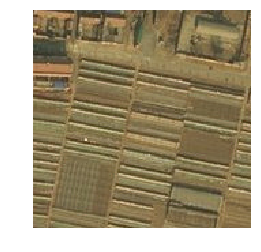

In [11]:
plt.imshow(plt.imread(image_name))
plt.axis("off")
plt.show()

In [12]:
image = cv2.imread(image_name)
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
gray = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)

r, g, b = image[:,:,2], image[:,:,1], image[:,:,0]
h, s, v = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

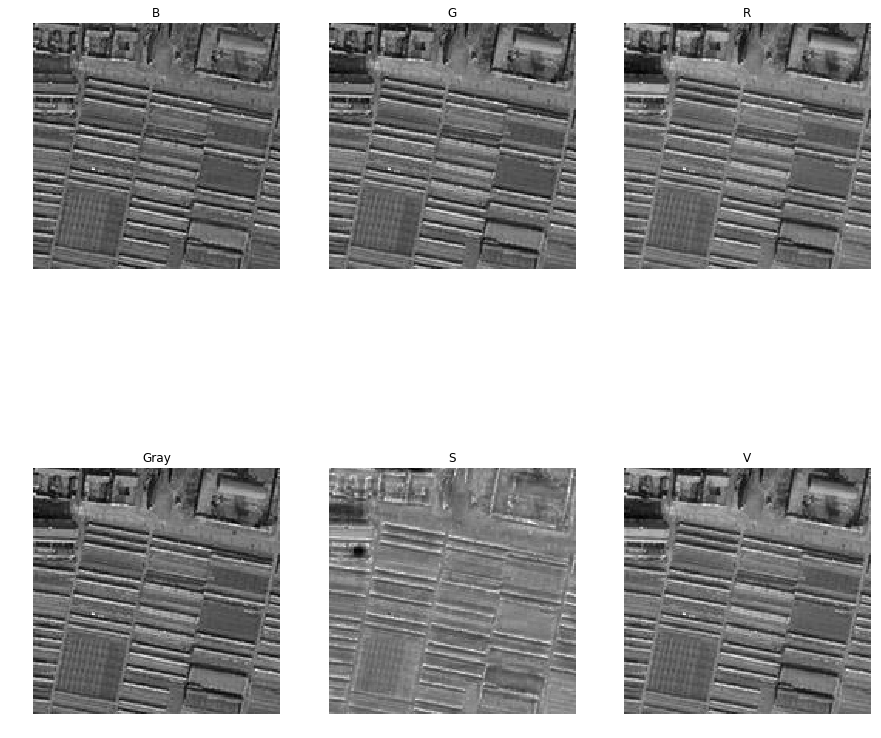

In [13]:
fig = plt.figure(figsize=(15,15))

plt.subplot(2,3,1)
plt.imshow(b, cmap=plt.cm.gray)
plt.axis("off")
plt.title("B")

plt.subplot(2,3,2)
plt.imshow(g, cmap=plt.cm.gray)
plt.axis("off")
plt.title("G")

plt.subplot(2,3,3)
plt.imshow(r, cmap=plt.cm.gray)
plt.axis("off")
plt.title("R")

plt.subplot(2,3,4)
plt.imshow(gray, cmap=plt.cm.gray)
plt.axis("off")
plt.title("Gray")

plt.subplot(2,3,5)
plt.imshow(s, cmap=plt.cm.gray)
plt.axis("off")
plt.title("S")

plt.subplot(2,3,6)
plt.imshow(v, cmap=plt.cm.gray)
plt.axis("off")
plt.title("V")

plt.show()

In [14]:
# gray = ndimage.interpolation.zoom(gray, 3)
# image = ndimage.interpolation.zoom(image, 3)

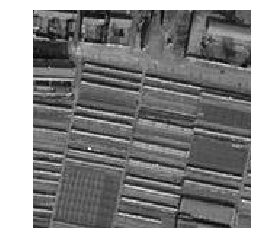

In [15]:
slice_index = (slice(0,150),slice(0,150))
plot_image(gray[slice_index])

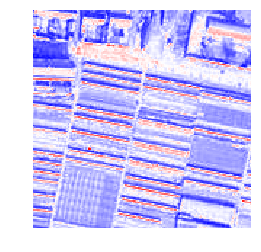

In [16]:
plot_image(gray[slice_index], cmap=plt.cm.bwr)

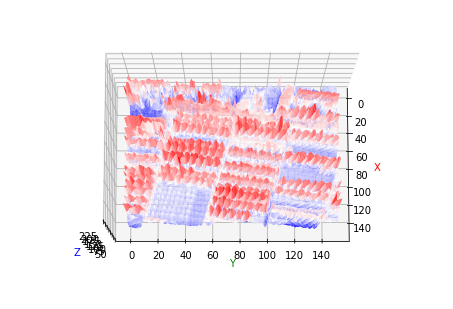

In [17]:
plot_surface(gray[slice_index])

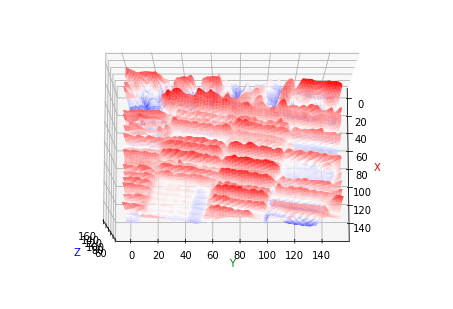

In [18]:
blur = cv2.bilateralFilter(gray,1,300,2)
blur = cv2.bilateralFilter(blur,1,300,2)
blur = cv2.bilateralFilter(blur,1,300,2)

plot_surface(blur[slice_index])

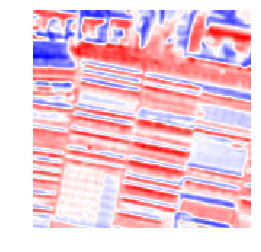

In [19]:
plot_image(blur[slice_index], cmap=plt.cm.bwr)

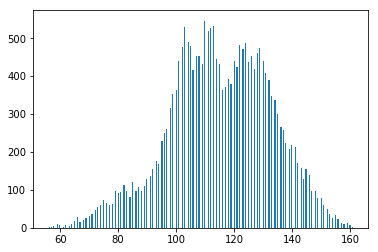

In [20]:
n, bins, patches = plt.hist(blur[slice_index].flatten(), 256)

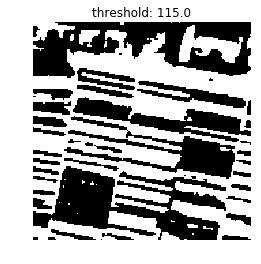

True

In [21]:
threshold, mask = cv2.threshold(blur, 100, 256, cv2.THRESH_OTSU)
# threshold, mask = cv2.threshold(blur, 100, 256, cv2.THRESH_BINARY)
plot_image(mask, title="threshold: {}".format(threshold))
cv2.imwrite("gray.png", mask)

In [22]:
image_copy = image.copy()
morph_open = cv2.morphologyEx(mask, cv2.MORPH_OPEN, np.ones((2,2), dtype=np.uint8))
a, contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
_ = cv2.drawContours(image_copy[slice_index], contours, -1, (0, 0, 255), -1)

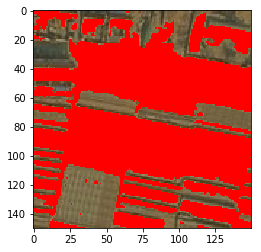

In [23]:
plt.imshow(image_copy[slice_index][:,:,::-1])